In [1]:
import torch
import umap
import anndata
import numpy as np
import os
import gc
import pandas as pd
import timeit
import warnings
warnings.filterwarnings('ignore')
import faiss
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sklearn
from scipy import stats
import scanpy as sc
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph
#from datasets import AnnDataset, NumpyDataset
import matplotlib.pyplot as plt
import anndata
from matplotlib.pyplot import figure
from multiprocessing import Process
from sklearn.cluster import KMeans
from fast_generator_ipsc import *
from fast_functions_ipsc import *

Global seed set to 0


scVI ready


/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
bulkdata = anndata.read_h5ad('bulkdata.h5ad')

In [3]:
bulkdata

AnnData object with n_obs × n_vars = 25 × 17156
    obs: 'pids'
    var: 'gene_symbols'

In [4]:
bulkdata.X.sum(axis=1)

array([10000.   , 10000.   ,  9999.999, 10000.001, 10000.001, 10000.   ,
        9999.999,  9999.999,  9999.998, 10000.   , 10000.001,  9999.998,
       10000.   , 10000.001, 10000.   ,  9999.999, 10000.001, 10000.   ,
       10000.   , 10000.001, 10000.002, 10000.001, 10000.   , 10000.001,
        9999.999], dtype=float32)

In [5]:
pids = np.array(bulkdata.obs['pids'])
pids.shape

(25,)

In [6]:
bulkpids = pids
bulkpids

array(['iMGL_D0_rep1_TPM', 'iMGL_D0_rep2_TPM', 'iMGL_D0_rep3_TPM',
       'iMGL_D1_rep1_TPM', 'iMGL_D1_rep2_TPM', 'iMGL_D1_rep3_TPM',
       'iMGL_D2_rep1_TPM', 'iMGL_D2_rep2_TPM', 'iMGL_D2_rep3_TPM',
       'iMGL_D3_rep1_TPM', 'iMGL_D3_rep2_TPM', 'iMGL_D3_rep3_TPM',
       'iMGL_D4_rep1_TPM', 'iMGL_D4_rep2_TPM', 'iMGL_D4_rep3_TPM',
       'iMGL_DMSO_rep1_TPM', 'iMGL_DMSO_rep2_TPM',
       'iMGL_GW3965_30nM_rep1_TPM', 'iMGL_GW3965_30nM_rep2_TPM',
       'iMGL_GW3965_300nM_rep1_TPM', 'iMGL_GW3965_300nM_rep2_TPM',
       'iMGL_T0901317_30nM_rep1_TPM', 'iMGL_T0901317_30nM_rep2_TPM',
       'iMGL_T0901317_100nM_rep1_TPM', 'iMGL_T0901317_100nM_rep2_TPM'],
      dtype=object)

In [7]:
hvmask = np.load('hvmask.npy')

In [8]:
if bulkdata.X.max() > 10:
    sc.pp.log1p(bulkdata)

In [9]:
bulkdata.X.max()

5.829498

In [10]:
bulkdata = bulkdata[:,hvmask]

In [11]:
sc.tl.pca(bulkdata, n_comps=20)

In [12]:
bulkdata

AnnData object with n_obs × n_vars = 25 × 6013
    obs: 'pids'
    var: 'gene_symbols'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [13]:
BATCH_SIZE = 2

if BATCH_SIZE == 1:
    cluster_labels = []
    for i in range(len(pids)):
        cluster_labels.append(0)
else:
    kmeans = KMeans(n_clusters=BATCH_SIZE, random_state=0).fit(bulkdata.obsm['X_pca'])
    cluster_labels = kmeans.labels_

In [14]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [15]:
# select representatives
pnums = []
for i in range(len(bulkdata.X)):
    pnums.append(i)
pnums=np.array(pnums)

if BATCH_SIZE == 1:
    center = (bulkdata.obsm['X_pca']).mean(axis=0)
    sqdist = ((bulkdata.obsm['X_pca'] - center)**2).sum(axis=1)
    
    representatives = [pnums[np.argmin(sqdist)]]
    
else:
    centers=[]
    representatives=[]
    repredic={}

    for i in range(len(np.unique(cluster_labels))):
        mask = (cluster_labels==i)
        cluster = bulkdata.obsm['X_pca'][mask]
        cluster_patients = pnums[mask]
        center = cluster.mean(axis=0)
        centers.append(center)

        # find the closest patient
        sqdist = ((cluster - center)**2).sum(axis=1)

        cluster_representative = cluster_patients[np.argmin(sqdist)]
        representatives.append(cluster_representative)
        repredic[i] = cluster_representative

    centers = np.array(centers)


In [16]:
representatives

[8, 21]

In [17]:
init_cluster_labels = cluster_labels
init_representatives = representatives

In [18]:
# umap for sample bulk
dimred=umap.UMAP(min_dist=0.3,n_neighbors=3)
vis_bulk=dimred.fit_transform(bulkdata.obsm['X_pca'])

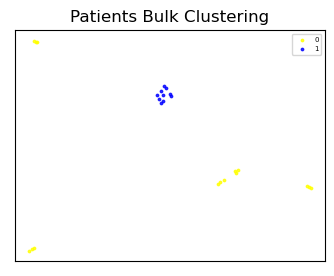

In [19]:
# sample plot
fig, ax = plt.subplots(figsize=(4,3),dpi=100)
colormap = ['yellow','blue','gray','red','green','black','darkgreen','darkorange','crimson',\
            'purple','navy','aquamarine','plum','violet','olive','steelblue']

for i in range(BATCH_SIZE):
    group = vis_bulk[np.array(cluster_labels)==i] #uz34
    ax.scatter(group[:,0],group[:,1],c=colormap[i],alpha=0.8,s=3,label=i)


plt.title('Patients Bulk Clustering')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

write init reps and cluster labels:

In [20]:

f=open('init_cluster_labels_'+str(BATCH_SIZE)+'.txt','w')
for i in range(len(init_cluster_labels)):
    f.write(str(init_cluster_labels[i])+'\n')
f.close()

f=open('init_representatives_'+str(BATCH_SIZE)+'.txt','w')
for i in range(len(init_representatives)):
    f.write(str(init_representatives[i])+'\n')
f.close()


In [34]:
representatives

[8, 21]

In [33]:
### test round
#cluster_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#representatives=[13]
#len(os.listdir('geneset'))

In [35]:

#highly variable geneset

gsets=[]
for r in representatives:
    gsetdata = np.load('geneset/'+pids[r]+'.npy')
    gsets.append(gsetdata)
gsets = np.concatenate(gsets,axis=0)
gdata = anndata.AnnData(gsets)
sc.pp.log1p(gdata)
sc.pp.highly_variable_genes(gdata)
hvset = gdata.var.highly_variable
np.save('hvset.npy',hvset)


In [36]:
hvset.sum()

685

In [37]:
adatas = []
for i in range(len(pids)):
    ad = anndata.read_h5ad('sample_sc/'+pids[i]+'.h5ad')
    #ad = ad[:,hvmask]
    print((ad.X.sum(axis=1)).mean())
    adatas.append(ad)

10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0


In [38]:
for ad in adatas:
    x = ad.X
    x = x[x>0]
    print(x.min())

17.574692
18.60119
16.21797
16.644476
16.968325
15.256825
16.711538
17.79359
17.86423
16.909746
17.190573
16.12903
18.101889
16.537622
17.876785
17.419077
16.938175
17.962118
16.709707
17.101326
17.910934
17.913122
17.313875
16.888725
17.32673


### end of init bulk analysis

In [39]:
### read cluster labels and representatives


f=open('init_cluster_labels_2.txt','r')
lines = f.readlines()


init_cluster_labels = []
init_representatives = []

for l in lines:
    init_cluster_labels.append(int(l.strip()))
f.close()


f=open('init_representatives_2.txt','r')
lines = f.readlines()

for l in lines:
    init_representatives.append(int(l.strip()))
    
    
f.close()


cluster_labels = init_cluster_labels
representatives = init_representatives



In [40]:
representatives

[8, 21]

In [41]:
### read pids
f = open('pids.txt','r')
lines = f.readlines()
pids=[]
for l in lines:
    pids.append(l.strip())
f.close()

In [42]:

hvmask = np.load('hvmask.npy')
hvset = np.load('hvset.npy')
bulknorm = anndata.read_h5ad('bulkdata.h5ad')

devices=['cuda:0','cuda:1','cuda:2','cuda:3','cuda:4','cuda:5','cuda:6','cuda:7']


In [43]:
from scipy import sparse

In [44]:

#for i in range(len(pids)):
#    adata = anndata.read_h5ad('dense_sample_sc/'+pids[i]+'.h5ad')
#    x = sparse.csr_matrix(adata.X)
#    bdata = anndata.AnnData(x)
#    bdata.obs = adata.obs
#    bdata.var = adata.var
#    bdata.write('sample_sc/'+pids[i]+'.h5ad')

In [45]:
len(pids)

25

In [46]:

repremodels = []

c=0
for rp in [representatives[1]]:
    device = devices[c]
    c+=1
    pid = pids[rp]
    repremodels.append(\
                       fastrecon(pid=pid,\
                      tgtpid=None,device=device,k=15,diagw=1,vaesteps=200,gansteps=100,save=True,path=None)\
                      )

INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|█████████████████████| 200/200 [04:01<00:00,  1.12s/it, loss=350, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████████████████| 200/200 [04:01<00:00,  1.21s/it, loss=350, v_num=1]
0, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=330, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=330, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=327, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=327, v_num=1]
1, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=323, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=323, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=323, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=323, v_num=1]
2, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=324, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=324, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=319, v_num=1]
3, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=325, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=320, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=320, v_num=1]
4, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=321, v_num=1]
5, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.00it/s, loss=323, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.01s/it, loss=323, v_num=1]
6, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=325, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=319, v_num=1]
7, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=319, v_num=1]
8, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=319, v_num=1]
9, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=320, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=320, v_num=1]
10, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=320, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=320, v_num=1]
11, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=319, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=318, v_num=1]
12, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.01s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.02s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.03s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=318, v_num=1]
13, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=318, v_num=1]
14, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=316, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=319, v_num=1]
15, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=315, v_num=1]
16, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=319, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=319, v_num=1]
17, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=319, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=317, v_num=1]
18, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=321, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=314, v_num=1]
19, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=317, v_num=1]
20, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=316, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=314, v_num=1]
21, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=319, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=318, v_num=1]
22, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=314, v_num=1]
23, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=314, v_num=1]
24, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.27s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.35s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=318, v_num=1]
25, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=311, v_num=1]
26, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=315, v_num=1]
27, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=319, v_num=1]
28, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=315, v_num=1]
29, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.35s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.35s/it, loss=316, v_num=1]
30, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=315, v_num=1]
31, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=317, v_num=1]
32, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=313, v_num=1]
33, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]
34, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=314, v_num=1]
35, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=316, v_num=1]
36, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=311, v_num=1]
37, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=317, v_num=1]
38, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=314, v_num=1]
39, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=319, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=315, v_num=1]
40, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]
41, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=311, v_num=1]
42, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=317, v_num=1]
43, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=313, v_num=1]
44, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
45, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=316, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=311, v_num=1]
46, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=313, v_num=1]
47, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=313, v_num=1]
48, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.01s/it, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.01s/it, loss=317, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.01s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.02s/it, loss=312, v_num=1]
49, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=316, v_num=1]
50, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=318, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=318, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=313, v_num=1]
51, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=316, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.37s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.38s/it, loss=312, v_num=1]
52, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.37s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.37s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.38s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.38s/it, loss=313, v_num=1]
53, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.37s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.38s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.36s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.36s/it, loss=313, v_num=1]
54, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.38s/it, loss=315, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.39s/it, loss=315, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=313, v_num=1]
55, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=311, v_num=1]
56, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.27s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.36s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=316, v_num=1]
57, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=313, v_num=1]
58, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=311, v_num=1]
59, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.12s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=314, v_num=1]
60, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=310, v_num=1]
61, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=313, v_num=1]
62, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=314, v_num=1]
63, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.32s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=311, v_num=1]
64, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]
65, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=314, v_num=1]
66, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=312, v_num=1]
67, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=314, v_num=1]
68, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=313, v_num=1]
69, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=310, v_num=1]
70, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=311, v_num=1]
71, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]
72, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=316, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=316, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]
73, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=308, v_num=1]
74, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]
75, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]
76, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]
77, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=311, v_num=1]
78, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]
79, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]
80, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]
81, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=314, v_num=1]
82, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]
83, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=310, v_num=1]
84, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=309, v_num=1]
85, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]
86, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]
87, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=309, v_num=1]
88, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=309, v_num=1]
89, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=308, v_num=1]
90, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=310, v_num=1]
91, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=312, v_num=1]
92, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.32s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.29s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=309, v_num=1]
93, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.31s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=308, v_num=1]
94, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.30s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.27s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.28s/it, loss=304, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=304, v_num=1]
95, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.26s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=307, v_num=1]
96, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=311, v_num=1]
97, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.22s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.19s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.21s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=308, v_num=1]
98, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.20s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=307, v_num=1]
99, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=309, v_num=1]


In [47]:
# check training history
model= repremodels[0]
#plt.plot( model.history['kl_global_train'])

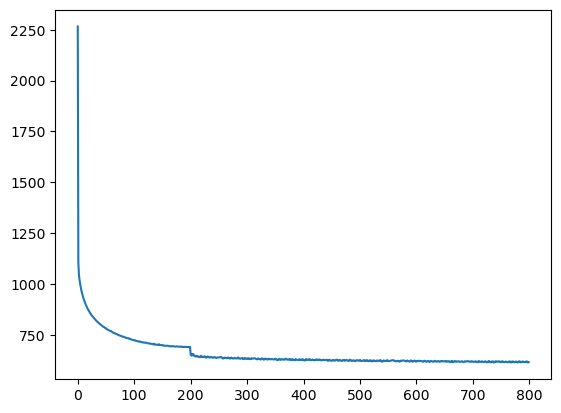

In [48]:
plt.plot( model.history['train_loss_epoch'])

In [49]:
torch.save(model.module.state_dict(), 'test_recon_1')

In [50]:
#model = fastgenerator(adj = adj,variances = variances,markermask = None,bulk=bulk,geneset_len = geneset_len,adata=adata,\
#                n_hidden=256,n_latent=32,dropout_rate=0,countbulkweight=0,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,\
#                power=2,corrbulkweight=0,meanbias=0)
#model.module.load_state_dict(torch.load('test_recon_1'))

In [51]:
adata = model.adata

In [52]:
adata

AnnData object with n_obs × n_vars = 4248 × 6698
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltype', 'cellidx', 'selfw', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'neighbors', 'neighborx'

In [53]:
#pid = pids[21]
#adata,adj,variances,bulk,geneset_len = setdata(pid,tgtpid=None,device='cuda:5',k=15,diagw=1.0,bulksource = -1)
#model = fastgenerator(adj,variances,None,None,geneset_len,adata,n_hidden=256,n_latent=32,dropout_rate=0)

In [54]:
#model.module.load_state_dict(torch.load('ipsc_models/fastreconst2_'+pid))

In [55]:
### get stage 1 reconstruction
pid = representatives[1]



model._validate_anndata(adata)
fastgenerator.setup_anndata(adata)
scdl = model._make_data_loader(
        adata=adata,batch_size = adata.X.shape[0]
)

x_r = []
for tensors in scdl:
    samples = model.module.sample(tensors, n_samples=1,bound=0)
    x_r.append(np.array(samples))
    
x_r = np.concatenate(x_r) 
x_r = x_r[:,:hvmask.sum()]

INFO     Generating sequential column names                                                  


In [56]:
#adata = anndata.read_h5ad('sample_sc/'+pids[pid]+'.h5ad') ###
#sc.pp.normalize_total(adata,1e4)
#adata.X = adata.X.todense()
#adata = adata[:,hvmask]
adata

AnnData object with n_obs × n_vars = 4248 × 6698
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltype', 'cellidx', 'selfw', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'neighbors', 'neighborx'

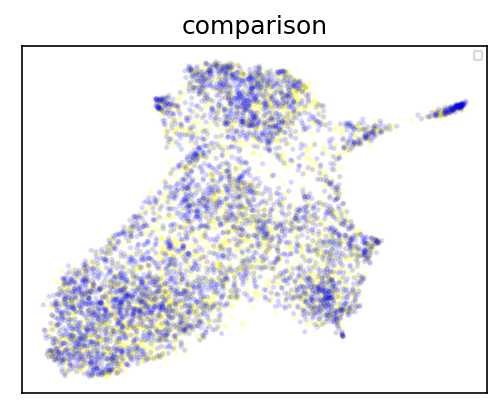

In [57]:
from sklearn.decomposition import PCA
xr = x_r
xr = xr*(xr>1)

xm = np.concatenate([xr[:,:hvmask.sum()],adata.X[:,:hvmask.sum()]],axis=0)
n_dim = 100

#xm=xm*(xm>100)

xmdata=AnnData(xm)
#sc.pp.normalize_total(xmdata,1e4)
sc.pp.log1p(xmdata)
xm=xmdata.X

pca = PCA(n_components=n_dim)
#pca.fit(xm)
xmpca = pca.fit_transform(xm)

dimred=umap.UMAP()#min_dist=0.1,n_neighbors=15)
xm2d=dimred.fit_transform(xmpca)

fig, ax = plt.subplots(figsize=(4,3),dpi=150)

#celltypes = np.unique(adata.obs['cell.type'])

colors=[]
for i in range(len(x_r)):
    colors.append('yellow')
for i in range(len(adata.X)):
    colors.append('blue')

ax.scatter(xm2d[:,0],xm2d[:,1],c=colors,alpha=0.1,s=3)
    
plt.title('comparison')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [58]:
xr = xr[:,:hvmask.sum()]
xo = adata.X[:,:hvmask.sum()]
br = xr.mean(axis=0)
bo = xo.mean(axis=0)
np.sum((br - bo)**2)

127323.3

In [15]:
### load trained reconstruct stage 1 models

repremodels = []

c=0
for rp in representatives:
    device = devices[c]
    c+=1
    pid = pids[int(rp)]
    adata,adj,variances,bulk,geneset_len = setdata(pid,None,device=device,k=15,diagw=1.0)
    reconmodel = fastgenerator(adj = adj,variances = variances,markermask = None,bulk=bulk,geneset_len = geneset_len,adata=adata,\
                n_hidden=256,n_latent=32,dropout_rate=0,countbulkweight=0,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,\
                power=2,corrbulkweight=0,meanbias=0)
    reconmodel.module.load_state_dict(torch.load('ipsc_models/fast_reconst1_'+str(pid)))
    reconmodel.module.eval()
    repremodels.append(
                reconmodel
                      )

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


In [16]:
repremodels

SCVI Model with the following params: 
n_hidden: 256, n_latent: 32, n_layers: 1, dropout_rate: 0, dispersion: gene, gene_likelihood:
zinb, latent_distribution: normal
Training status: Not Trained

SCVI Model with the following params: 
n_hidden: 256, n_latent: 32, n_layers: 1, dropout_rate: 0, dispersion: gene, gene_likelihood:
zinb, latent_distribution: normal
Training status: Not Trained

[, ]

### stage 2 recon using pseudo bulk
full batch mode

In [59]:
repremodels2=[]
i=0
for rp in [representatives[1]]:
    i=i%8
    device = devices[i+1]
    pid = pids[int(rp)]
    repremodels2.append(reconst_pretrain2(pid,repremodels[i],device,k=15,diagw=1.0,vaesteps=100,gansteps=50,save=True))
    i+=1

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|█████████████████████| 100/100 [01:46<00:00,  1.05s/it, loss=324, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████| 100/100 [01:46<00:00,  1.06s/it, loss=324, v_num=1]
0, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]
1, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
2, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]
3, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=314, v_num=1]
4, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
5, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=312, v_num=1]
6, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
7, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]
8, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]
9, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
10, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]
11, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=313, v_num=1]
12, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=309, v_num=1]
13, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=313, v_num=1]
14, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=306, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=306, v_num=1]
15, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
16, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
17, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
18, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.13s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.14s/it, loss=310, v_num=1]
19, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=309, v_num=1]
20, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]
21, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.18s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.25s/it, loss=310, v_num=1]
22, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]
23, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=309, v_num=1]
24, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]
25, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]
26, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
27, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
28, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]
29, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=307, v_num=1]
30, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=312, v_num=1]
31, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]
32, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
33, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=311, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=319, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=319, v_num=1]
34, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.11s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
35, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=312, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]
36, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=313, v_num=1]
37, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]
38, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=311, v_num=1]
39, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
40, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=308, v_num=1]
41, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
42, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
43, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]
44, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=307, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=312, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=312, v_num=1]
45, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=314, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.08s/it, loss=314, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=308, v_num=1]
46, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=310, v_num=1]
47, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=310, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=310, v_num=1]
48, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss=309, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.07s/it, loss=309, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.04s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.05s/it, loss=311, v_num=1]
49, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.16s/it, loss=313, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.15s/it, loss=313, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=311, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it, loss=311, v_num=1]


In [60]:
representatives

[8, 21]

In [61]:
adata.X.shape

(4248, 6698)

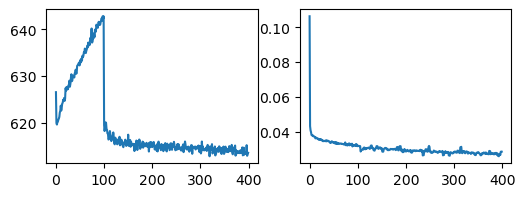

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6, 2))
ax1.plot(repremodels2[0].history['train_loss_epoch'])
ax2.plot(repremodels2[0].history['kl_global_train'])

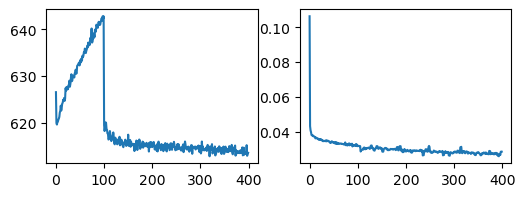

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6, 2))
ax1.plot(repremodels2[0].history['train_loss_epoch'])
ax2.plot(repremodels2[0].history['kl_global_train'])

In [67]:
rp = 0
rpid = representatives[rp]
reprepid = pids[rpid]
adata,adj,variances,bulk,geneset_len = setdata(reprepid,None,device=device,k=15,diagw=1.0)


INFO     Generating sequential column names                                                  


In [68]:
### get stage 2 reconstruction


reconmodel1 = repremodels2[rp]
adata = repremodels2[rp].adata
reconmodel1._validate_anndata(adata)
fastgenerator.setup_anndata(adata)
scdl = reconmodel1._make_data_loader(
        adata=adata,batch_size = adata.X.shape[0]
)

x_r = []
for tensors in scdl:
    samples = reconmodel1.module.sample(tensors, n_samples=1,bound=0)
    x_r.append(np.array(samples))
    
x_r = np.concatenate(x_r) 
x_r = x_r[:,:hvmask.sum()]

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


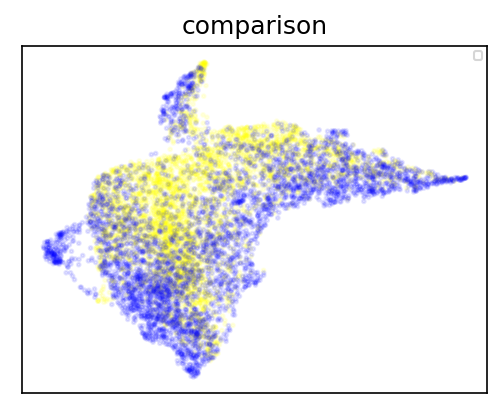

In [70]:
from sklearn.decomposition import PCA
xr = x_r
xr = xr*(xr>1)

xm = np.concatenate([xr[:,:hvmask.sum()],adata.X[:,:hvmask.sum()]],axis=0)
n_dim = 100

#xm=xm*(xm<100)

xmdata=AnnData(xm)
#sc.pp.normalize_total(xmdata,1e4)
#sc.pp.log1p(xmdata)
xm=xmdata.X

pca = PCA(n_components=100)
#pca.fit(xm)
xmpca = pca.fit_transform(xm)

dimred=umap.UMAP(min_dist=0.3,n_neighbors=15)
xm2d=dimred.fit_transform(xmpca)

fig, ax = plt.subplots(figsize=(4,3),dpi=150)

#celltypes = np.unique(adata.obs['cell.type'])

colors=[]
for i in range(len(x_r)):
    colors.append('yellow')
for i in range(len(adata.X)):
    colors.append('blue')

ax.scatter(xm2d[:,0],xm2d[:,1],c=colors,alpha=0.1,s=3)
    
plt.title('comparison')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

### pretrain using GAN, real bulk, full batch mode


### stage 3 recon function for real bulk

In [11]:

pp = 8

fac = 0.05

def unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model0 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight =116*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                      power=2,upperbound=99999,meanbias=0)
    if type(premodel)==type('string'):
        model0.module.load_state_dict(torch.load(premodel))
    else:
        model0.module.load_state_dict(premodel.module.state_dict())
    
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * fac
    model0.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model0.module.state_dict(), 'tmp/model0')
    return model0.history


def unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model1 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 16*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model1.module.load_state_dict(torch.load('tmp/model0'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model1.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model1.module.state_dict(), 'tmp/model1')
    return model1.history

def unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model2 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 16*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model2.module.load_state_dict(torch.load('tmp/model1'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model2.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model2.module.state_dict(), 'tmp/model2')
    return model2.history

def unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model3 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 64*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model3.module.load_state_dict(torch.load('tmp/model2'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model3.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model3.module.state_dict(), 'tmp/model3')
    return model3.history

def unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model4 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 128*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model4.module.load_state_dict(torch.load('tmp/model3'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model4.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model4.module.state_dict(), 'tmp/model4')
    return model4.history

def unisemi5(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))
    lr = adata.X.shape[0] / (4e3) * 4e-4
    lr = 2e-4* fac
    model.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model.module.state_dict(), 'tmp/model')
    return model.history

def recon2(reprepid,tgtpid,premodel,device='cuda:1',k=15,diagw=1.0):
    adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device,k,diagw,bulksource=0)
    #adata.X = (adata.X.todense())
    
    hvmask = np.load('hvmask.npy')
    maxexpr = adata.X[:,:hvmask.sum()].max()
    upperbounds = [maxexpr/2, maxexpr/4, maxexpr/8, maxexpr/(8*np.sqrt(2)),maxexpr/16, maxexpr/32,maxexpr/64]     
       
    
    #(5) tgt bulk
    #tgtdata = anndata.read_h5ad('COVID_HV_GT/'+tgtpid+'.h5ad')
    bulk = torch.tensor(bulk).to(device)
    
    
    batch_size = adata.X.shape[0] #np.min([adata.X.shape[0],9000])
    
    
    #(6) semiprofiling
    fastgenerator.setup_anndata(adata)
    histdic={}
    
    hist = unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total0'] = hist['train_loss_epoch']
    histdic['bulk0'] = hist['kl_global_train']

    gc.collect()
    torch.cuda.empty_cache() 

    hist = unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[0],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total1'] = hist['train_loss_epoch']
    histdic['bulk1'] = hist['kl_global_train']

    gc.collect()
    torch.cuda.empty_cache() 
    hist = unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[1],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total2'] = hist['train_loss_epoch']
    histdic['bulk2'] = hist['kl_global_train']

    gc.collect()
    torch.cuda.empty_cache() 
    
    hist = unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[2],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)
    histdic['total3'] = hist['train_loss_epoch']
    histdic['bulk3'] = hist['kl_global_train']
    
    gc.collect()
    torch.cuda.empty_cache() 
    hist = unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[3],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total4'] = hist['train_loss_epoch']
    histdic['bulk4'] = hist['kl_global_train']
 
    gc.collect()
    torch.cuda.empty_cache() 

    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                     markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbounds[3],meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))
    # reconstruction
    xsemi = []
    scdl = model._make_data_loader(
            adata=adata,batch_size=batch_size
    )

    for tensors in scdl:
        samples = model.module.sample(tensors, n_samples=1)
        xsemi.append(samples)
    xsemi = np.array(torch.cat(xsemi))[:,:hvmask.sum()]
    
    #torch.save(model.module.state_dict(), 'ipsc_models/semi_'+reprepid+"_to_"+tgtpid)
    
    del model
    gc.collect()
    torch.cuda.empty_cache() 
    return histdic,xsemi,adata

In [169]:
repremodels4=[]
i=0
for rp in [representatives[-1]]:
    i=i%8
    device = devices[i%8]
    reprepid = pids[rp]
    #premodel = 'ipsc_models/fast_reconst1_'+reprepid

    premodel = 'ipsc_models/fastreconst3_'+reprepid
    tgtpid = reprepid
    hists,xsemi,adata = recon2(reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)



INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [03:16<00:00,  2.76it/s, loss=611, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [03:16<00:00,  2.03it/s, loss=611, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:38<00:00,  2.12it/s, loss=343, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:38<00:00,  2.52it/s, loss=343, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:38<00:00,  2.74it/s, loss=308, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s, loss=308, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:12<00:00,  2.78it/s, loss=410, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:12<00:00,  2.75it/s, loss=410, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:37<00:00,  1.91it/s, loss=534, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:37<00:00,  2.54it/s, loss=534, v_num=1]


In [170]:
model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                 markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                 dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                 power=2,upperbound=10000,meanbias=0)

model.module.load_state_dict(torch.load('tmp/model4'))
repremodels4.append(model)

In [171]:

#reconpid = pids[representatives[0]]
#adata,adj,variances,bulk,geneset_len = setdata(reconpid,None,device=device,k=15,diagw=1.0)

#reconmodel = fastgenerator(adj = adj,variances = variances,markermask = None,bulk=bulk,geneset_len = geneset_len,adata=adata,\
#                n_hidden=256,n_latent=32,dropout_rate=0,countbulkweight=0,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,\
#                power=2,corrbulkweight=0,meanbias=0)
####reconmodel.module.load_state_dict(torch.load('ipsc_models/fastreconst2_'+str(reconpid)))
#reconmodel.module.load_state_dict(torch.load('ipsc_models/fast_reconst1_'+str(reconpid)))
#reconmodel.module.eval()


In [177]:
'''Setting up reconstruction model'''

repnum = -1

reconmodel4 = repremodels4[repnum]

#adata = anndata.read_h5ad('COVID_HV_GT/'+pids[representatives[repnum]]+'.h5ad')
adata = repremodels4[repnum].adata
#reconmodel = repremodels2[0]
reconmodel4._validate_anndata(adata)
fastgenerator.setup_anndata(adata)

reconmodel4.module.load_state_dict(torch.load('tmp/model1'))
scdl = reconmodel4._make_data_loader(
        adata=adata,batch_size = adata.X.shape[0]
)

x_r = []
for tensors in scdl:
    samples = reconmodel4.module.sample(tensors, n_samples=1,bound=0)
    x_r.append(np.array(samples))
    
x_r = np.concatenate(x_r) 
x_r = x_r[:,:hvmask.sum()]


INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


In [173]:
'''model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                     markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbounds[3],meanbias=0)
model.module.load_state_dict(torch.load('tmp/model3'))
x_r = []
for tensors in scdl:
    samples = model.module.sample(tensors, n_samples=1,bound=0)
    x_r.append(np.array(samples))
    
x_r = np.concatenate(x_r) 
#x_r = x_r[:,:hvmask.sum()]'''

"model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,                     markermask=None,bulk=bulk,n_hidden=256,n_latent=32,                     dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,                     power=2,upperbound=upperbounds[3],meanbias=0)\nmodel.module.load_state_dict(torch.load('tmp/model3'))\nx_r = []\nfor tensors in scdl:\n    samples = model.module.sample(tensors, n_samples=1,bound=0)\n    x_r.append(np.array(samples))\n    \nx_r = np.concatenate(x_r) \n#x_r = x_r[:,:hvmask.sum()]"

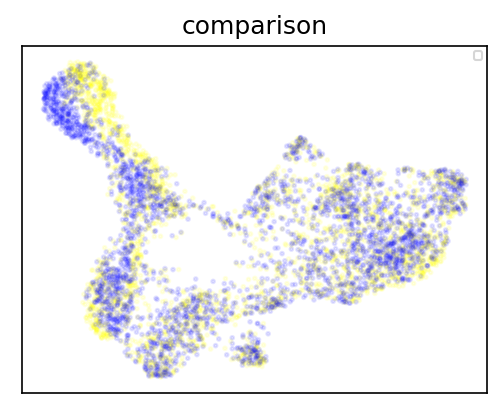

In [178]:
# repre umap
from sklearn.decomposition import PCA
xr = x_r

xr = xr*(xr>1)

xm = np.concatenate([xr[:,:hvmask.sum()],adata.X[:,:hvmask.sum()]],axis=0)
n_dim = 100

#xm=xm*(xm>100)

xmdata=AnnData(xm)
#sc.pp.normalize_total(xmdata,1e4)
sc.pp.log1p(xmdata)
xm=xmdata.X

pca = PCA(n_components=40)
#pca.fit(xm)
xmpca = pca.fit_transform(xm)

dimred=umap.UMAP(min_dist=0.3,n_neighbors=15)
xm2d=dimred.fit_transform(xmpca)

fig, ax = plt.subplots(figsize=(4,3),dpi=150)

#celltypes = np.unique(adata.obs['cell.type'])

colors=[]
for i in range(len(x_r)):
    colors.append('yellow')
for i in range(len(adata.X)):
    colors.append('blue')

ax.scatter(xm2d[:,0],xm2d[:,1],c=colors,alpha=0.1,s=3)
    
plt.title('comparison')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

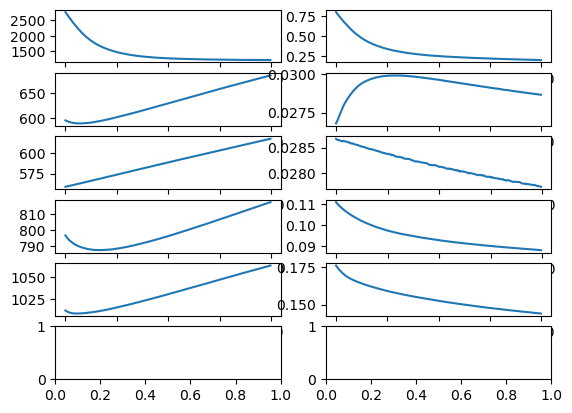

In [179]:
histdic = hists
fig, axs = plt.subplots(6,2)
axs[0][0].plot(histdic['total0'])
axs[0][1].plot(histdic['bulk0'])
axs[1][0].plot(histdic['total1'])
axs[1][1].plot(histdic['bulk1'])
axs[2][0].plot(histdic['total2'])
axs[2][1].plot(histdic['bulk2'])
axs[3][0].plot(histdic['total3'])
axs[3][1].plot(histdic['bulk3'])
axs[4][0].plot(histdic['total4'])
axs[4][1].plot(histdic['bulk4'])

In [180]:
xr = xr[:,:hvmask.sum()]
xo = adata.X[:,:hvmask.sum()]
br = xr.mean(axis=0)
bo = xo.mean(axis=0)
np.sum((br - bo)**2)

40626.15

In [94]:
pid = pids[0]

In [99]:
adata = anndata.read_h5ad('sample_sc/'+pid+'.h5ad')
adata.X = adata.X.todense()
hvmask = np.load('hvmask.npy')
adata = adata[:,hvmask]
pseudobulk = adata.X.mean(axis=0)
bhvmask = np.load('hvmask.npy')

bulkdata = anndata.read_h5ad('bulkdata.h5ad')
bulkdata = bulkdata[:,hvmask]
pidnum = list(bulkdata.obs['pids']).index(pid)
bulks = bulkdata.X
bulk = np.array(bulks[pidnum]).reshape((-1))
pseudobulk[:hvmask.sum()]=bulk
bulk = pseudobulk

In [100]:
pseudobulk = adata.X.mean(axis=0)

In [103]:
(pseudobulk - bulk).max()

ArrayView(85.5647, dtype=float32)

In [102]:
pseudobulk.max()

88.73398

In [18]:
reprefile = 'training_rec/eer_representatives_1.txt' 
clusterfile = 'training_rec/eer_cluster_labels_1.txt' 

os.system('cp init_cluster_labels_1.txt '+clusterfile)
os.system('cp init_representatives_1.txt '+reprefile)




cp: cannot stat 'init_cluster_labels_1.txt': No such file or directory
cp: cannot stat 'init_representatives_1.txt': No such file or directory


256

In [19]:
representatives

['8', '21']

c=0
for rp in range(25):
    device = devices[c]
    c+=1
    c=c%8
    pid = pids[rp]
    repremodels.append(\
                       fastrecon(pid=pid,\
                      tgtpid=None,device=device,k=15,diagw=1,vaesteps=100,gansteps=100,save=True,path=None)\
                      )

In [16]:
cluster_labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Semi-profiling

In [20]:
((bulkdata.X)[:,hvmask]).sum(axis=1)

array([3456.0847, 3449.0315, 3459.8435, 3449.9336, 3455.4214, 3449.1726,
       3480.5098, 3466.1123, 3476.4446, 3475.3064, 3467.694 , 3475.7383,
       3477.0435, 3470.656 , 3467.2554, 3424.2334, 3422.907 , 3387.9165,
       3388.2034, 3364.3513, 3357.422 , 3384.9255, 3373.6892, 3374.7363,
       3374.8145], dtype=float32)

2889

In [70]:

b = 1
for a in range(25):
    print( ((bulkdata.X[a] - bulkdata.X[b])**2).sum() )

2.8977728
0.0
2.9936206
133.92563
138.0777
142.83957
140.84084
140.81049
139.88667
256.86316
183.9929
161.81607
162.3088
160.33188
161.22202
258.19128
251.64697
268.06528
280.50833
304.14407
300.71442
270.54718
271.8165
278.96628
294.77582


In [71]:

gts=[]
for i in range(len(pids)):
    pid = pids[i]
    adata = anndata.read_h5ad('sample_sc/' + pid + '.h5ad') ### norm_sample_sc
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')
    
del adata

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

In [73]:

pp = 8

fac = 0.5
lrdis=3

def unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model0 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight =1*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                      power=2,upperbound=99999,meanbias=0)
    if type(premodel)==type('string'):
        model0.module.load_state_dict(torch.load(premodel))
    else:
        model0.module.load_state_dict(premodel.module.state_dict())
    
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * fac
    model0.train(max_epochs=400//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model0.module.state_dict(), 'tmp/model0')
    return model0.history


def unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model1 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 4*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model1.module.load_state_dict(torch.load('tmp/model0'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model1.train(max_epochs=400//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model1.module.state_dict(), 'tmp/model1')
    return model1.history

def unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model2 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 16*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model2.module.load_state_dict(torch.load('tmp/model1'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model2.train(max_epochs=200//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model2.module.state_dict(), 'tmp/model2')
    return model2.history

def unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model3 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 64*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model3.module.load_state_dict(torch.load('tmp/model2'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model3.train(max_epochs=200//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model3.module.state_dict(), 'tmp/model3')
    return model3.history

def unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model4 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 128*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model4.module.load_state_dict(torch.load('tmp/model3'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4* fac
    model4.train(max_epochs=400//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model4.module.state_dict(), 'tmp/model4')
    return model4.history

def unisemi5(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))
    lr = adata.X.shape[0] / (4e3) * 4e-4
    lr = 2e-4* fac
    model.train(max_epochs=200//lrdis, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model.module.state_dict(), 'tmp/model')
    return model.history

def fast_semi(reprepid,tgtpid,premodel,device='cuda:1',k=15,diagw=1.0):
    adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device,k,diagw,bulksource=1)
    #adata.X = (adata.X.todense())
    
    
    hvmask = np.load('hvmask.npy')
    maxexpr = adata.X[:,:hvmask.sum()].max()
    upperbounds = [maxexpr/2, maxexpr/4, maxexpr/8, maxexpr/(8*np.sqrt(2)),maxexpr/16, maxexpr/32,maxexpr/64]     
       
    
    #(5) tgt bulk
    #tgtdata = anndata.read_h5ad('COVID_HV_GT/'+tgtpid+'.h5ad')
    
    
    '''
    #bulk diff
    bulkdata = anndata.read_h5ad('bulkdata.h5ad')
    bulknorm = np.array(bulkdata.X[:,hvmask])
    tgtrealbulk = bulknorm[list(pids).index(tgtpid)]
    reprerealbulk = bulknorm[list(pids).index(reprepid)]
    bulkdiff = tgtrealbulk - reprerealbulk
    bulkdiff = np.concatenate([bulkdiff,np.ones(bulk.shape[0]-bulkdiff.shape[0])],axis=0)
    bulk = bulk + bulkdiff
    bulk = bulk*(bulk>=0)'''

    
    '''
    #bulktransformation
    bulkdata = anndata.read_h5ad('bulkdata.h5ad')
    bulknorm = np.array(bulkdata.X[:,hvmask])
    tgtrealbulk = bulknorm[list(pids).index(tgtpid)]
    reprerealbulk = bulknorm[list(pids).index(reprepid)]
    pseudobulk = (np.array(adata.X)).mean(axis=0)[:len(tgtrealbulk)]
    bt = np.array((pseudobulk+1e-6)/(reprerealbulk+1e-6))
    bt = np.concatenate([bt,np.ones(pseudobulk.shape[0]-bt.shape[0])],axis=0)
    #bt = np.nan_to_num(bt,nan=1)
    bulk = tgtrealbulk*bt'''
    
    
    ### ratio between reprerealbulk and tgt real bulk
    bulkdata = anndata.read_h5ad('bulkdata.h5ad')
    bulknorm = np.array(bulkdata.X[:,hvmask])
    tgtrealbulk = bulknorm[list(pids).index(tgtpid)]
    reprerealbulk = bulknorm[list(pids).index(reprepid)]
    pseudobulk = (np.array(adata.X)).mean(axis=0)[:len(tgtrealbulk)]
    ratio = np.array((tgtrealbulk+0.1)/(reprerealbulk+0.1))
    ratio = np.concatenate([ratio,np.ones(pseudobulk.shape[0]-ratio.shape[0])],axis=0)
    bulk = pseudobulk * ratio
    
    
    ### pseudo bulk
    '''
    tgtdata = anndata.read_h5ad('sample_sc/'+tgtpid+'.h5ad')
    tgtX = np.array(tgtdata.X.todense())
    tgtpseudobulk = (tgtX.mean(axis=0))[hvmask]
    bulk = tgtpseudobulk'''
    
    
    
    bulk = np.concatenate([bulk,np.zeros(geneset_len)])
    bulk = torch.tensor(bulk).to(device)
    

    
    
    batch_size = adata.X.shape[0] #np.min([adata.X.shape[0],9000])
    
    #(6) semiprofiling
    fastgenerator.setup_anndata(adata)
    histdic={}
    
    hist = unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total0'] = hist['train_loss_epoch']
    histdic['bulk0'] = hist['kl_global_train']

    gc.collect()
    torch.cuda.empty_cache() 

    hist = unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[0],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total1'] = hist['train_loss_epoch']
    histdic['bulk1'] = hist['kl_global_train']

    gc.collect()
    torch.cuda.empty_cache() 
    hist = unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[1],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total2'] = hist['train_loss_epoch']
    histdic['bulk2'] = hist['kl_global_train']

    gc.collect()


    torch.cuda.empty_cache() 
    
    hist = unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[2],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)
    histdic['total3'] = hist['train_loss_epoch']
    histdic['bulk3'] = hist['kl_global_train']
    

    gc.collect()
    torch.cuda.empty_cache() 
    hist = unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[3],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)

    histdic['total4'] = hist['train_loss_epoch']
    histdic['bulk4'] = hist['kl_global_train']
    
 

    gc.collect()
    torch.cuda.empty_cache() 

    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                     markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbounds[3],meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))
    # reconstruction
    xsemi = []
    scdl = model._make_data_loader(
            adata=adata,batch_size=batch_size
    )

    for tensors in scdl:
        samples = model.module.sample(tensors, n_samples=1)
        xsemi.append(samples)
    xsemi = np.array(torch.cat(xsemi))[:,:hvmask.sum()]
    
    torch.save(model.module.state_dict(), 'ipsc_models/test_semi_'+reprepid+"_to_"+tgtpid)
    np.save('semidata/test_fast'+ reprepid+'_to_'+tgtpid,xsemi)
    
    del model
    gc.collect()
    torch.cuda.empty_cache() 
    return histdic,xsemi

In [9]:
reprepid=pids[13]
tgtpid=pids[0]
device='cuda:3'
adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device,k=15,diagw=1.0,bulksource=1)

INFO     Generating sequential column names                                                  


In [10]:
tgtdata = anndata.read_h5ad('sample_sc/'+pids[0]+'.h5ad')
tgtpseudobulk = (np.array(tgtdata.X.todense())).mean(axis=0)
tgtpseudobulk = tgtpseudobulk[hvmask]

In [11]:
bulkdata = anndata.read_h5ad('bulkdata.h5ad')
bulknorm = np.array(bulkdata.X[:,hvmask])
tgtrealbulk = bulknorm[list(pids).index(tgtpid)]
reprerealbulk = bulknorm[list(pids).index(reprepid)]
pseudobulk = (np.array(adata.X)).mean(axis=0)[:len(tgtrealbulk)]
bt = np.array((pseudobulk+1e-6)/(reprerealbulk+1e-6))
bt = np.concatenate([bt,np.ones(pseudobulk.shape[0]-bt.shape[0])],axis=0)
#bt = np.nan_to_num(bt,nan=1)
bulk = tgtrealbulk*bt


In [12]:
np.sum((tgtrealbulk-reprerealbulk)**2)

16647.453

In [13]:
bulkdata

AnnData object with n_obs × n_vars = 25 × 17156
    obs: 'pids'
    var: 'gene_symbols'

In [14]:
np.sum((bulk-pseudobulk)**2)

42233.85654868409

In [15]:
np.sum((reprerealbulk-pseudobulk)**2)

45478.96

In [16]:
np.sum((tgtrealbulk-bulk)**2)

109443.89987525239

In [17]:
bulkdiff = tgtrealbulk - reprerealbulk
pseudobulkdiff = tgtpseudobulk - pseudobulk

In [18]:
pbmask = (np.abs(pseudobulkdiff) > 5)
rbmask = (np.abs(bulkdiff) > 5)

In [19]:
(pbmask*rbmask).sum()

18

In [20]:
bt.min()

1.6013723325158935e-07

In [21]:
tgtrealbulk[bulkdiff.argmax()]

81.088776

In [22]:
reprerealbulk[bulkdiff.argmax()]

26.79485

In [23]:
reprerealbulk[bulkdiff.argmin()]

118.07062

In [24]:
tgtrealbulk[bulkdiff.argmin()]

22.990915

In [25]:
np.abs(bulkdiff)

array([0.05621234, 0.07799636, 0.10866112, ..., 0.32024235, 0.01335371,
       0.37837332], dtype=float32)

(array([ 1.,  0.,  0.,  0.,  1.,  7., 12.,  4.,  0.,  1.]),
 array([-95.07970428, -80.14234161, -65.20497894, -50.26761627,
        -35.3302536 , -20.39288902,  -5.45552588,   9.48183727,
         24.4192009 ,  39.35656357,  54.29392624]),
 <BarContainer object of 10 artists>)

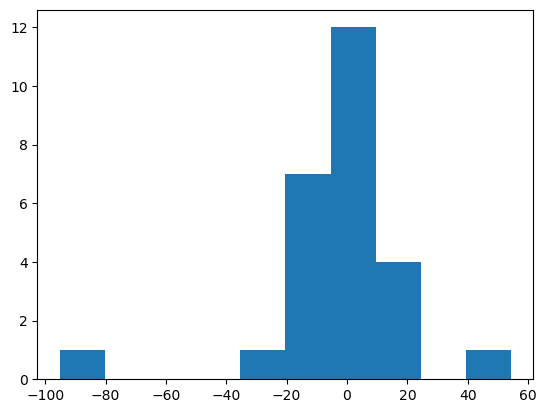

In [34]:
plt.hist(bulkdiff[np.abs(bulkdiff)>5])

In [35]:
bulkdiff[np.abs(bulkdiff)>5]

array([  6.1556754,  -7.505361 ,   5.3379817, -95.079704 ,   5.5191765,
         7.5609055,   5.040553 ,  -6.791663 , -19.399809 , -17.109905 ,
         6.638286 , -34.05826  ,   6.192322 ,   9.690168 ,  12.719839 ,
        54.293926 ,  15.659503 ,   6.8343887,   7.1952868,  -8.768507 ,
        18.020508 ,   6.217013 ,   5.853348 ,   5.771993 , -13.913378 ,
        -6.842873 ], dtype=float32)

In [56]:
tgtrealbulk[np.abs(bulkdiff)>5]

array([ 7.80122  ,  4.769172 ,  7.3562775, 22.990915 ,  5.753423 ,
       88.73277  ,  9.535262 ,  2.1854925,  3.0726368, 12.162614 ,
        7.417589 , 22.948612 ,  9.240518 , 26.64225  , 18.732279 ,
       81.088776 , 16.133184 , 76.508675 ,  7.643657 , 20.291462 ,
       24.13718  ,  7.0331035, 18.275347 ,  6.815256 ,  8.796774 ,
        5.179177 ], dtype=float32)

In [37]:
reprerealbulk[np.abs(bulkdiff)>5]

array([  1.6455446 ,  12.274533  ,   2.0182958 , 118.07062   ,
         0.23424682,  81.17187   ,   4.494709  ,   8.977156  ,
        22.472446  ,  29.27252   ,   0.779303  ,  57.006874  ,
         3.0481958 ,  16.952082  ,   6.0124397 ,  26.79485   ,
         0.47368166,  69.674286  ,   0.44837043,  29.059969  ,
         6.116672  ,   0.81609076,  12.421999  ,   1.0432631 ,
        22.710152  ,  12.02205   ], dtype=float32)

In [57]:
#list(tgtpseudobulk[np.abs(bulkdiff)>5])

In [58]:
#list(pseudobulk[np.abs(bulkdiff)>5])

In [88]:
#reprefile = 'training_rec/init_representatives_4.txt' 
#clusterfile = 'training_rec/init_cluster_labels_4.txt' 
reprefile = 'training_rec/eer_representatives_1.txt' 
clusterfile = 'training_rec/eer_cluster_labels_1.txt' 


f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [44]:
!nvidia-smi

Sun Aug 20 13:16:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M10           Off  | 00000000:3D:00.0 Off |                  N/A |
| N/A   25C    P8     8W /  53W |      3MiB /  8129MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M10           Off  | 00000000:3E:00.0 Off |                  N/A |
| N/A   

In [59]:
pid

21

In [89]:
pid=23#representatives[1]

device = 'cuda:3'

if pid not in representatives:
    
    device = devices[pid%8]
    tgtpid = pids[pid]
    cluster = int(cluster_labels[pid])
    #cluster = 0 ###################################333
    repre_num = representatives[cluster]
    reprepid = pids[int(repre_num)]
    premodel = 'ipsc_models/fastreconst2_'+reprepid
    hists,xsemi = fast_semi(reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)
    
    #xsemi = np.load('semidata/fast'+reprepid+'_to_'+tgtpid+'.npy')

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 133/133: 100%|█████████████████████| 133/133 [04:14<00:00,  1.90s/it, loss=329, v_num=1]

`Trainer.fit` stopped: `max_epochs=133` reached.


Epoch 133/133: 100%|█████████████████████| 133/133 [04:14<00:00,  1.91s/it, loss=329, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 133/133: 100%|█████████████████████| 133/133 [04:12<00:00,  1.90s/it, loss=330, v_num=1]

`Trainer.fit` stopped: `max_epochs=133` reached.


Epoch 133/133: 100%|█████████████████████| 133/133 [04:12<00:00,  1.90s/it, loss=330, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 66/66: 100%|█████████████████████████| 66/66 [02:05<00:00,  1.91s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=66` reached.


Epoch 66/66: 100%|█████████████████████████| 66/66 [02:05<00:00,  1.90s/it, loss=325, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 66/66: 100%|█████████████████████████| 66/66 [02:06<00:00,  1.92s/it, loss=320, v_num=1]

`Trainer.fit` stopped: `max_epochs=66` reached.


Epoch 66/66: 100%|█████████████████████████| 66/66 [02:06<00:00,  1.91s/it, loss=320, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 133/133: 100%|█████████████████████| 133/133 [04:12<00:00,  1.89s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=133` reached.


Epoch 133/133: 100%|█████████████████████| 133/133 [04:12<00:00,  1.90s/it, loss=325, v_num=1]


In [90]:
histdic = hists

In [91]:
histdic.keys()

dict_keys(['total0', 'bulk0', 'total1', 'bulk1', 'total2', 'bulk2', 'total3', 'bulk3', 'total4', 'bulk4'])

In [92]:
xsemi = xsemi[:,:hvmask.sum()]

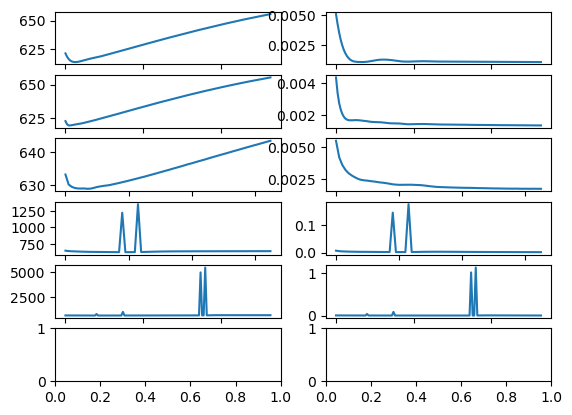

In [93]:
fig, axs = plt.subplots(6,2)
axs[0][0].plot(histdic['total0'])
axs[0][1].plot(histdic['bulk0'])
axs[1][0].plot(histdic['total1'])
axs[1][1].plot(histdic['bulk1'])
axs[2][0].plot(histdic['total2'])
axs[2][1].plot(histdic['bulk2'])
axs[3][0].plot(histdic['total3'])
axs[3][1].plot(histdic['bulk3'])
axs[4][0].plot(histdic['total4'])
axs[4][1].plot(histdic['bulk4'])

In [66]:
pid = 16
device = devices[pid%8]
tgtpid = pids[pid]
cluster = int(cluster_labels[pid])
#cluster = 0 ###################################333
repre_num = representatives[cluster]
reprepid = pids[int(repre_num)]
premodel = 'ipsc_models/fastreconst2_'+reprepid
adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device='cuda:3',
                                               k=15,diagw=1.0,bulksource=1)
#adata.X = (adata.X.todense())


hvmask = np.load('hvmask.npy')
maxexpr = adata.X[:,:hvmask.sum()].max()
upperbounds = [maxexpr/2, maxexpr/4, maxexpr/8, maxexpr/(8*np.sqrt(2)),maxexpr/16, maxexpr/32,maxexpr/64]     


INFO     Generating sequential column names                                                  


In [67]:
model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                 markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                 dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                 power=2,upperbound=upperbounds[3],meanbias=0)

path = 'ipsc_models/fastreconst2_'+pids[21] 

semipath = 'tmp/model4'

model.module.load_state_dict(torch.load(  semipath   )) 

<All keys matched successfully>

In [68]:
# reconstruction
xsemi = []
scdl = model._make_data_loader(
        adata=adata,batch_size=adata.X.shape[0]
)

for tensors in scdl:
    samples = model.module.sample(tensors, n_samples=1)
    xsemi.append(samples)
xsemi = np.array(torch.cat(xsemi))[:,:hvmask.sum()]

In [37]:
tgtrealbulk.max()

149.28636

In [ ]:
bulkdata = anndata.read_h5ad('bulkdata.h5ad')
bulknorm = np.array(bulkdata.X[:,hvmask])
tgtrealbulk = bulknorm[list(pids).index(tgtpid)]
reprerealbulk = bulknorm[list(pids).index(reprepid)]
pseudobulk = (np.array(adata.X)).mean(axis=0)[:len(tgtrealbulk)]
ratio = np.array((tgtrealbulk+0.1)/(reprerealbulk+0.1))
ratio = np.concatenate([ratio,np.ones(pseudobulk.shape[0]-ratio.shape[0])],axis=0)
bulk = pseudobulk * ratio
    

In [ ]:
bulk.shape

In [ ]:
ratio.min()

In [ ]:
pseudobulk.shape

In [ ]:
tgtdata = anndata.read_h5ad('sample_sc/'+tgtpid+'.h5ad')
tgtX = np.array(tgtdata.X.todense())
tgtpseudobulk = (tgtX.mean(axis=0))[hvmask]

In [ ]:
mask = (bulk>0) * (tgtpseudobulk>0)
res = stats.pearsonr(tgtpseudobulk[mask],bulk[mask])
print(res)

In [ ]:
print(tgtpseudobulk.sum())
print(bulk.sum())

In [94]:
pid=23

In [95]:
from sklearn.decomposition import PCA


xgt = gts[pid]
xrep = gts[representatives[cluster_labels[pid]]]
xs = xsemi * (xsemi>1)
xm = np.concatenate([xrep,xgt,xs],axis=0)

#xm = xm * (xm>1)

xm = np.log1p(xm)

pcatool =  PCA(n_components=100)
xm=pcatool.fit_transform(xm)




#umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
umap_reduc=umap.UMAP()
xmumap = umap_reduc.fit_transform(xm)




colors = []
for i in range(len(xrep)):
    colors.append('blue')
    
for i in range(len(xgt)):
    colors.append('yellow')
    
for i in range(len(xsemi)):
    colors.append('red')


In [96]:
ls = xsemi.shape[0]

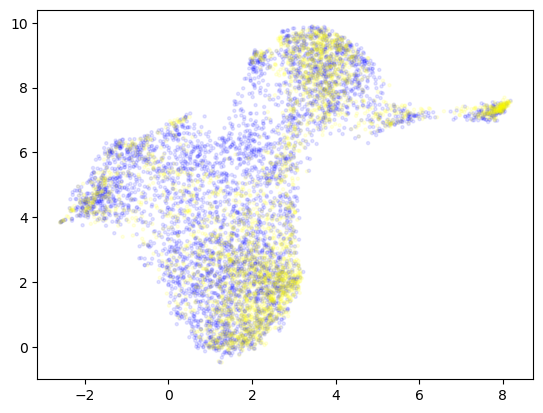

In [97]:
plt.scatter(x = xmumap[:-ls,0], y =xmumap[:-ls,1],c = colors[:-ls],s=5,alpha=0.1)

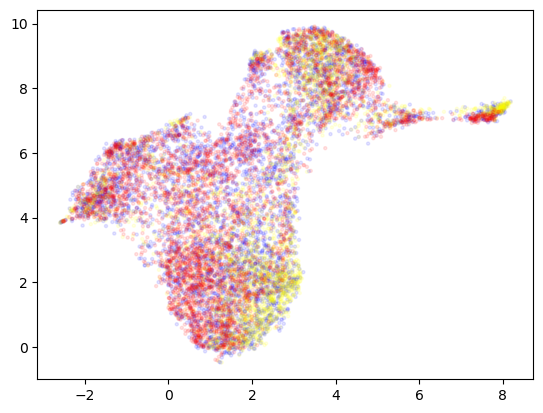

In [98]:
plt.scatter(x = xmumap[:,0], y = xmumap[:,1],c = colors[:],s=5,alpha=0.1)

In [ ]:
cluster_labels

In [22]:
for i in range(25):
    print(i, gts[i].shape[0])

0 1730
1 1762
2 1754
3 2112
4 2538
5 2673
6 1905
7 1931
8 2301
9 4208
10 3205
11 3002
12 3100
13 2889
14 2868
15 3582
16 4799
17 4620
18 4532
19 5403
20 2699
21 8744
22 9122
23 3421
24 2339


In [40]:
bulkdata.obs['sample_id']

KeyError: 'sample_id'

In [39]:
scdata = anndata.read_h5ad('scdata_t10_normed.h5ad')

In [40]:
from scipy import stats
for pid in range(25):
    vx = (np.array(bulknorm.X[pid]).reshape((-1)))
    vy = (scdata[scdata.obs['sample_id']==pids[pid]].X.mean(axis=0))
    vy = (np.array(vy)).reshape((-1))
    vy = vy
    vx=vx[hvmask]
    vy=vy[hvmask]
    res=stats.pearsonr(vx,vy)
    print(res)

PearsonRResult(statistic=0.9039848598958232, pvalue=0.0)
PearsonRResult(statistic=0.9101463406819128, pvalue=0.0)
PearsonRResult(statistic=0.8735387355157822, pvalue=0.0)
PearsonRResult(statistic=0.889275938005733, pvalue=0.0)
PearsonRResult(statistic=0.8696509305109874, pvalue=0.0)
PearsonRResult(statistic=0.8770845561445159, pvalue=0.0)
PearsonRResult(statistic=0.8806051240924693, pvalue=0.0)
PearsonRResult(statistic=0.8873583108781465, pvalue=0.0)
PearsonRResult(statistic=0.8764906704710509, pvalue=0.0)
PearsonRResult(statistic=0.8126957945423815, pvalue=0.0)
PearsonRResult(statistic=0.8497220183186398, pvalue=0.0)
PearsonRResult(statistic=0.8503749107516558, pvalue=0.0)
PearsonRResult(statistic=0.9020562039959711, pvalue=0.0)
PearsonRResult(statistic=0.871910974736971, pvalue=0.0)
PearsonRResult(statistic=0.8425406904063256, pvalue=0.0)
PearsonRResult(statistic=0.9030042922301064, pvalue=0.0)
PearsonRResult(statistic=0.9012026973835177, pvalue=0.0)
PearsonRResult(statistic=0.887227

In [41]:
1+1

2

In [ ]:
sc.tl.pca(scdata)

In [ ]:
sc.pp.neighbors(scdata)


In [ ]:
sc.tl.umap(scdata)

In [ ]:
sc.pl.umap(scdata,color='sample_id')

In [86]:
pid = 0
adata = scdata[scdata.obs['sample_id']==pids[pid]]
vx = np.array(adata.X.mean(axis=0)).reshape((-1))[hvmask]
vy = np.array(bulkdata.X[pid]).reshape((-1))[hvmask]
res = stats.pearsonr(vx,vy)
res

PearsonRResult(statistic=0.61066727124805, pvalue=0.0)

In [135]:
xmdata = anndata.AnnData(np.concatenate([xrep,xgt,xs],axis=0))
sc.pp.log1p(xmdata)

In [136]:
sc.tl.pca(xmdata)

In [137]:
sc.pp.neighbors(xmdata)

In [138]:
sc.tl.leiden(xmdata,resolution=0.5)

In [139]:
xmdata.obsm['X_umap'] =xmumap 

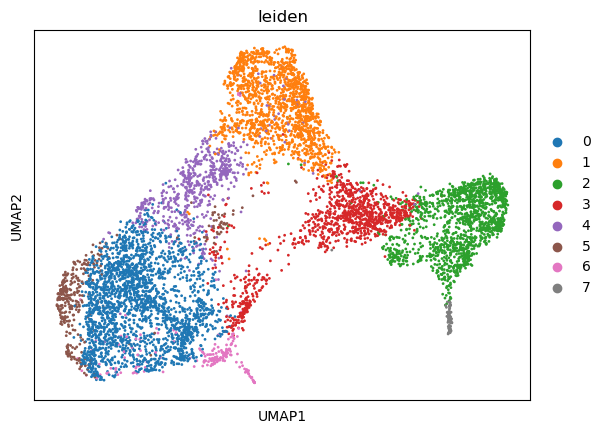

In [140]:
sc.pl.umap(xmdata,color='leiden')

In [141]:
xmdata.X.max()

8.760943

In [159]:
np.exp(xmdata[xmdata.obs['leiden']!='5'].X[:,1469]).mean()

ArrayView(5.6243944, dtype=float32)

In [160]:
np.exp(xmdata[xmdata.obs['leiden']=='5'].X[:,1469]).mean()

ArrayView(27.769135, dtype=float32)

In [164]:
bulkdata.X[0][hvmask][1469]


4.419452

In [165]:
pseudobulk[1469]

3.4724936

In [166]:
tgtpseudobulk[1469]

7.700664

In [145]:
sc.tl.rank_genes_groups(xmdata, 'leiden', method='t-test')

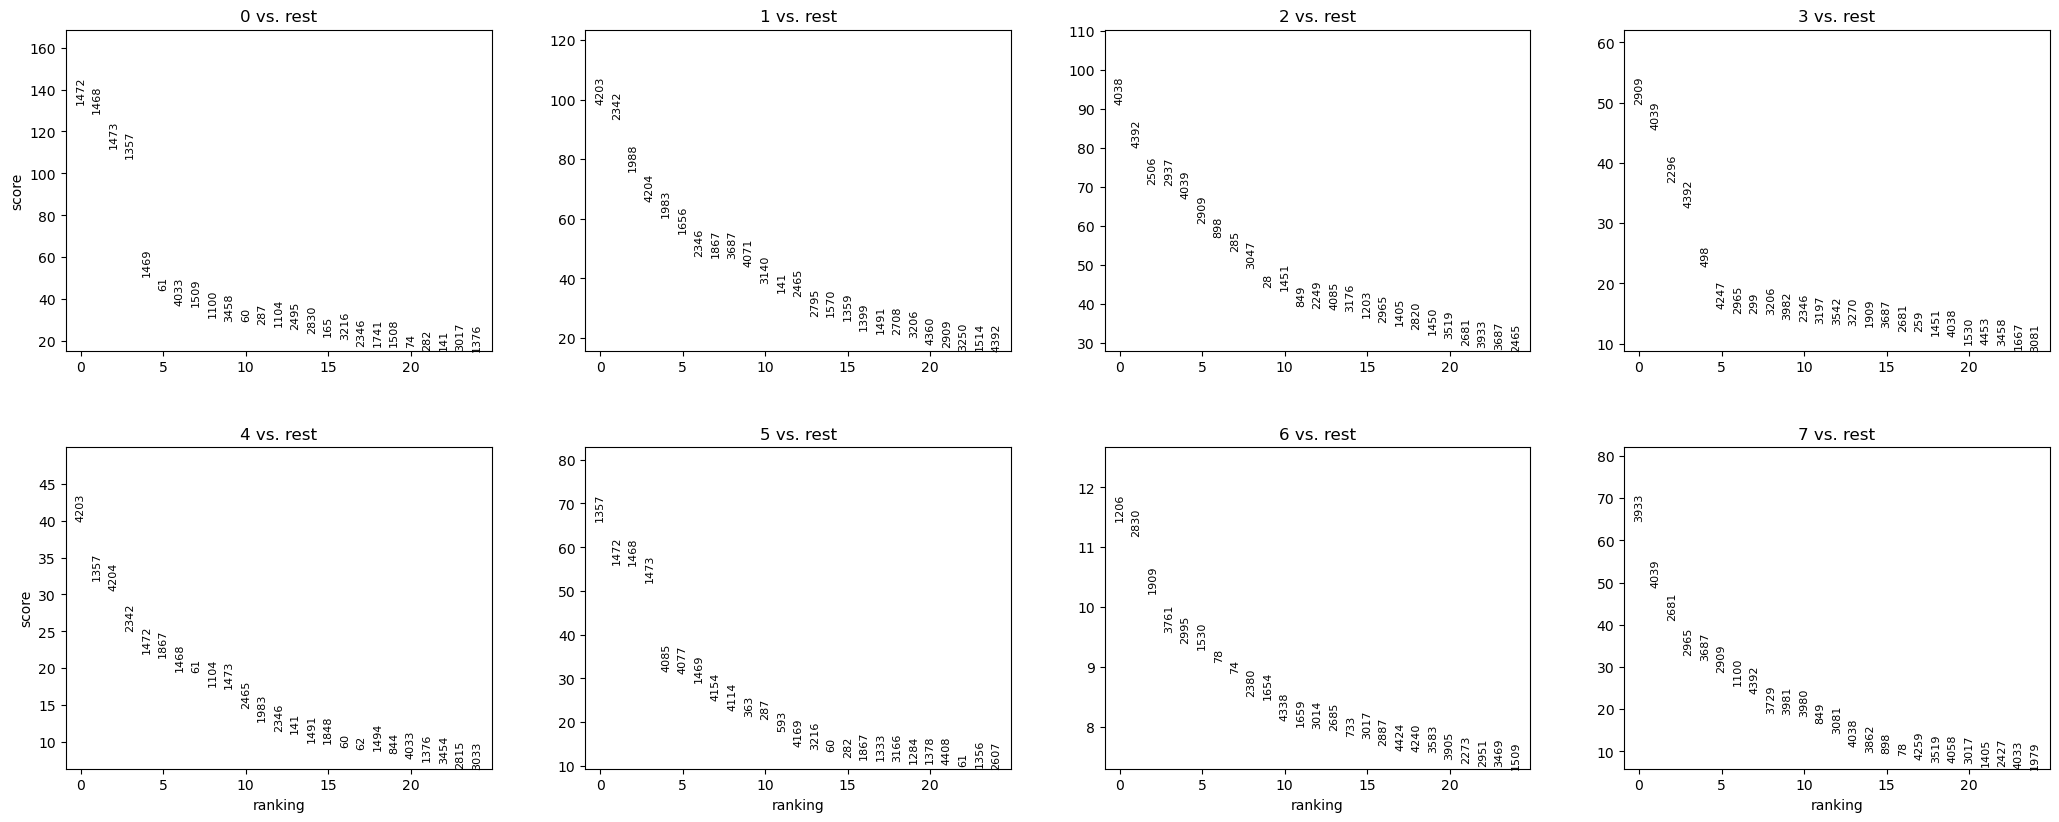

In [146]:
sc.pl.rank_genes_groups(xmdata, n_genes=25, sharey=False)

In [153]:
xmdata.uns['rank_genes_groups']['names'][4]

('1469', '1983', '4039', '498', '1472', '4085', '2995', '3687')

In [189]:
from scipy import stats

In [194]:
vx = reprerealbulk
vy = tgtrealbulk
res = stats.pearsonr(vx,vy)
res

PearsonRResult(statistic=0.762788281531295, pvalue=0.0)

In [254]:
device = devices[pid%8]
tgtpid = pids[0]
cluster = cluster_labels[pid]
repre_num = 13
reprepid = pids[repre_num]

k=15
diagw=1.0

adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device,k,diagw)
model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                 markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                 dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                 power=2,upperbound=upperbounds[3],meanbias=0)
model.module.load_state_dict(torch.load('tmp/model3'))
# reconstruction
xsemi2 = []
scdl = model._make_data_loader(
        adata=adata,batch_size=batch_size
)

for tensors in scdl:
    samples = model.module.sample(tensors, n_samples=1)
    xsemi2.append(samples)
xsemi2 = np.array(torch.cat(xsemi2))[:,:hvmask.sum()]


del model
gc.collect()
torch.cuda.empty_cache() 
    
    

INFO     Generating sequential column names                                                  


In [ ]:
from sklearn.decomposition import PCA


xgt = gts[pid]
xrep = gts[representatives[cluster_labels[pid]]]
xs = xsemi2 * (xsemi2>1)
xm = np.concatenate([xrep,xgt,xs],axis=0)

xm = xm * (xm>1)

xm = np.log1p(xm)

pcatool =  PCA(n_components=100)
xm=pcatool.fit_transform(xm)




#umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
umap_reduc=umap.UMAP()
xm = umap_reduc.fit_transform(xm)




colors = []
for i in range(len(xrep)):
    colors.append('blue')
    
for i in range(len(xgt)):
    colors.append('yellow')
    
for i in range(len(xsemi)):
    colors.append('red')


In [ ]:
plt.scatter(x = xm[:-ls,0], y = xm[:-ls,1],c = colors[:-ls],s=5,alpha=0.1)

In [ ]:
plt.scatter(x = xm[:,0], y = xm[:,1],c = colors[:],s=5,alpha=0.1)

In [ ]:
1+1

In [ ]:
maxlen = 0
for i in gts:
    if i.shape[0] > maxlen:
        maxlen = i.shape[0]
print(maxlen)

In [ ]:
np.save('semidata/fast'+reprepid+'_to_'+tgtpid+'.npy',xsemi)

In [ ]:
rnd = 1
for i in range(0,len(pids)):
    device = devices[i%4]
    repnum = cluster_labels[i]
    rep = representatives[repnum]
    print('start semiprofiling patient',str(i),'using',device,'and rep',str(rep))
    os.system('/mnt/data/jingtao2/anaconda3/envs/deep/bin/python semicommand.py '+str(i)+' '+str(device) + ' '+str(rnd))

In [ ]:
'semidata/fast'+reprepid+'_to_'+tgtpid+'.npy'

In [ ]:
### evaluation functions

def faiss_knn(query, x, n_neighbors=1):
    n_samples = x.shape[0]
    n_features = x.shape[1]
    x = np.ascontiguousarray(x)
    
    index = faiss.IndexFlatL2(n_features)
    #index = faiss.IndexFlatIP(n_features)
                  
    index.add(x)
    
    if n_neighbors < 2:
        neighbors = 2
    else: 
        neighbors = n_neighbors
    
    weights, targets = index.search(query, neighbors)

    #sources = np.repeat(np.arange(n_samples), neighbors)
    #targets = targets.flatten()
    #weights = weights.flatten()
    weights = weights[:,:n_neighbors]
    if -1 in targets:
        raise InternalError("Not enough neighbors were found. Please consider "
                            "reducing the number of neighbors.")
    return weights

def pearson_compare(query,x):
    return 0

def cos_compare(query,x):
    return 0


def pca_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dx=qxpca.fit_transform(qx)
    
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def umap_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dpca=qxpca.fit_transform(qx)
    umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
    dx = umap_reduc.fit_transform(dpca)
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def knncompare(query,x,n_neighbors=1,dist='PCA'):
    if dist == 'Euclidean':
        score = faiss_knn(query,x,n_neighbors=n_neighbors)
        score2 = faiss_knn(x,query,n_neighbors=n_neighbors)
    elif dist == 'Pearson':
        score = pearson_compare(query,x)
        score2 = pearson_compare(x,query)
    elif dist == 'cos':
        score = cos_compare(query,x)
        score2 = cos_compare(x,query)
    elif dist == 'PCA':
        score = pca_compare(query,x)
        score2 = pca_compare(x,query)
    elif dist == 'UMAP':
        score = umap_compare(query,x)
        score2 = umap_compare(x,query)
    else:
        score = 0
        print('distance option not found')
        
    return (score.mean() + score2.mean())/2

def normtotal(x,h=1e4):
    ratios = h/x.sum(axis=1)
    x=(x.T*ratios).T
    return x

In [ ]:
bulkdata = anndata.read_h5ad('bulkcount.h5ad')
sc.pp.log1p(bulkdata)
sc.tl.pca(bulkdata, svd_solver='arpack',n_comps=100)
reduced_bulk = bulkdata.obsm['X_pca']

In [ ]:
## active learning functions 
def pick_batch(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = [] 
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    
    new_representatives = copy.deepcopy(representatives)
    for i in range(batch_size):
        mp_index = np.array(lhet).argmax()
        mp = lmp[mp_index]
        
        new_representatives.append(mp)
        lhet.pop(mp_index)
        lmp.pop(mp_index)
    
    new_cluster_labels= update_membership(reduced_bulk=reduced_bulk,\
                      representatives=new_representatives)
    
    return new_representatives,new_cluster_labels

def pick_batch_eee(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = [] 
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=representatives,\
                            cluster_labels=cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    new_representatives = copy.deepcopy(representatives)
    new_cluster_labels = copy.deepcopy(cluster_labels)
    print('heterogeneities: ',lhet)
    for i in range(batch_size):
        new_num = len(new_representatives)
        mp_index = np.array(lhet).argmax()
        print(mp_index)
        lhet[mp_index] = -999
        bestp, new_cluster_labels, hets = best_patient(cluster_labels=new_cluster_labels,representatives=new_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=mp_index,new_num=new_num)
        
        new_representatives = new_representatives + [bestp]
    
    return new_representatives,new_cluster_labels

def best_patient(cluster_labels=init_cluster_labels,representatives=init_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=0,new_num=None):
    if new_num == None:
        new_num = len(representatives)
    pindices = np.where(np.array(cluster_labels)==cluster_num)[0]
    representative = representatives[cluster_num]
    hets=[]
    potential_new_labels = []
    for i in range(len(pindices)):
        potential_new_label = copy.deepcopy(cluster_labels)
        newrepre = pindices[i]
        het = 0
        if newrepre in representatives:
            hets.append(9999)
            potential_new_labels.append(potential_new_label)
            continue
        for j in range(len(pindices)):
            brepre = reduced_bulk[representative]
            brepre2 = reduced_bulk[newrepre]
            bj = reduced_bulk[pindices[j]]
            bdist1 = (brepre - bj)**2
            bdist1 = bdist1.sum()
            bdist1 = bdist1**0.5
            bdist2 = (brepre2 - bj)**2
            bdist2 = bdist2.sum()
            bdist2 = bdist2**0.5
            
            if bdist1 > bdist2:
                #print(pindices[j])
                het = het + bdist2
                potential_new_label[pindices[j]]=new_num
            else:
                het = het + bdist1
        hets.append(het)
        potential_new_labels.append(potential_new_label)
    hets = np.array(hets)
    bestp = pindices[np.argmin(hets)]
    new_cluster_labels = potential_new_labels[np.argmin(hets)]
    return bestp, new_cluster_labels, hets

def update_membership(reduced_bulk=reduced_bulk,\
                      representatives=init_representatives,\
                      
                     ):
    new_cluster_labels = []
    for i in range(len(reduced_bulk)):
        
        dists=[]
        #dist to repres
        for j in representatives:
            bdist = (reduced_bulk[j] - reduced_bulk[i])**2 
            bdist = bdist.sum()
            bdist = bdist**0.5
            dists.append(bdist)
        membership = np.array(dists).argmin()
        new_cluster_labels.append(membership)
    return new_cluster_labels

def compute_cluster_heterogeneity(cluster_number=0,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           ):
    semiflag=0
    
    representative = representatives[cluster_number]
    in_cluster_uncertainty = []
    cluster_labels = np.array(cluster_labels)
    cluster_patient_indices = np.where(cluster_labels==cluster_number)[0]
    
    for i in range(len(cluster_patient_indices)): # number of patients in this cluster except the representative
        
        patient_index = cluster_patient_indices[i]
        
        if patient_index in representatives:
            in_cluster_uncertainty.append(0)
            continue
            
        # distance between this patient and representative
        bdist = (reduced_bulk[representative] - reduced_bulk[patient_index])**2 
        bdist = bdist.sum()
        bdist = bdist**0.5
        
        ma = np.array(xdimsemis[patient_index]).copy(order='C')
        mb = np.array(xdimgts[representative]).copy(order='C')
        sdist = (faiss_knn(ma,mb,n_neighbors=1).mean())
        
        semiloss = np.log(1+gts[patient_index].sum(axis=0))- np.log(1+semis[patient_index].sum(axis=0))
        semiloss = semiloss**2
        semiloss = semiloss.sum()
        semiloss = semiloss**0.5
        
        #print(bdist,sdist,semiloss)
        
        uncertainty = bdist + sdist*discount_rate + semi_dis_rate * semiloss
        
        in_cluster_uncertainty.append(uncertainty)
        
    cluster_heterogeneity = np.array(in_cluster_uncertainty).sum()
    
    uncertain_patient = cluster_patient_indices[np.array(in_cluster_uncertainty).argmax()] 

    return cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient


In [ ]:
### load ground truth

hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

gts=[]
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/' + sid + '.h5ad')
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')
    
del adata
gc.collect()

In [ ]:
### load new semi results
t_start = timeit.default_timer()
semis=[]
for i in range(len(pids)):
    pid = pids[i]
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(gts[i])
    else:
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy')
        semis.append(xsem)
    print(i,end=', ')

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for loading semi')
### end of loading semi

In [ ]:
### PCA
t_start = timeit.default_timer()

X = np.concatenate([np.concatenate(gts,axis=0),np.concatenate(semis,axis=0)],axis=0)
X = np.log(X+1)
reducer =  PCA(n_components = 100,svd_solver = 'randomized')#randomized_svd(n_components=100)  #PCA(n_components=100)#
X_reduced = reducer.fit_transform(X)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for pca')
### end of pca

In [ ]:
### PCA
t_start = timeit.default_timer()

X = np.concatenate([np.concatenate(gts,axis=0),np.concatenate(semis,axis=0)],axis=0)
X = np.log(X+1)
reducer =  PCA(n_components = 100,svd_solver = 'randomized')#randomized_svd(n_components=100)  #PCA(n_components=100)#
X_reduced = reducer.fit_transform(X)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for pca')
### end of pca


### reduced data for patients
xdimgts=[]
xdimsemis=[]
offset=0
xused = X_reduced#X_UMAP # X_PCA
for i in range(len(pids)):
    xdimgts.append(xused[offset:(offset+gts[i].shape[0]),:])
    offset = offset+gts[i].shape[0]
for i in range(len(pids)):
    xdimsemis.append(xused[offset:(offset+semis[i].shape[0]),:])
    offset = offset+semis[i].shape[0]
### end 

### lowerbound
lbscores2 = []
lbgt = copy.deepcopy(X_reduced)
np.random.shuffle(lbgt)
lbgt1 = lbgt[:lbgt.shape[0]//2,:]
lbgt2 = lbgt[lbgt.shape[0]//2:,:]
ma = np.array(lbgt1).copy(order='C')
mb = np.array(lbgt2).copy(order='C')
lowerbound = faiss_knn(ma,mb,n_neighbors=1).mean()

### upperbound
ubscores = []
for i in range(len(pids)):
    gt = xdimgts[i]
    randomidx = np.random.randint(0,130)
    gtr = xdimgts[randomidx]
    ma = np.array(gt).copy(order='C')
    mb = np.array(gtr).copy(order='C')
    ubscore = faiss_knn(ma,mb,n_neighbors=1).mean()
    ubscores.append(ubscore)
upperbound = np.array(ubscores).mean()



### semi evaluation
t_start = timeit.default_timer()
scores = []
for i in range(len(pids)):
    pid = pids[i]
    if i in representatives:
        scores.append(lowerbound)
        continue
    gt = xdimgts[i]
    xs = xdimsemis[i]
    ma = np.array(gt).copy(order='C')
    mb = np.array(xs).copy(order='C')
    score = faiss_knn(ma,mb,n_neighbors=1).mean()
    scores.append(score)
semierror = np.array(scores).mean()

### naive evaluation
naivescores = []
for i in range(len(pids)):
    pid = pids[i]
    if i in representatives:
        naivescores.append(lowerbound)
        continue
    gt = xdimgts[i]
    repre = representatives[cluster_labels[i]]
    xs = xdimgts[repre]
    ma = np.array(gt).copy(order='C')
    mb = np.array(xs).copy(order='C')
    score = faiss_knn(ma,mb,n_neighbors=1).mean()
    naivescores.append(score)
naiveerror = np.array(naivescores).mean()


normednaive = (naiveerror - lowerbound)/(upperbound - lowerbound)
normedsemi = (semierror - lowerbound)/(upperbound - lowerbound)
t_end = timeit.default_timer()
print('naive:',naiveerror)
print('semi:',semierror)
print('upperbound:',upperbound)
print('lowerbound;',lowerbound)
print('normed naive:',normednaive)
print('normed semi:',normedsemi)
print(str(t_end-t_start),' for evaluation')

f=open('performance/conpensated6040rnd'+str(rnd)+'.txt','w')
f.write('naive:'+str(naiveerror)+'\n')
f.write('semi:'+str(semierror)+'\n')
f.write('upperbound:'+str(upperbound)+'\n')
f.write('lowerbound;'+str(lowerbound)+'\n')
f.write('normed naive:'+str(normednaive)+'\n')
f.write('normed semi:'+str(normedsemi)+'\n')
f.close()

In [ ]:
### active learning 
nrep, nlabels = pick_batch_eee(reduced_bulk=reduced_bulk,\
                representatives=representatives,\
                cluster_labels=cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=4\
               )
new_representatives = nrep
new_cluster_labels = nlabels
f=open('new_training_rec/eer_cluster_labels_'+str(rnd+1)+'.txt','w')
for i in range(len(new_cluster_labels)):
    f.write(str(new_cluster_labels[i])+'\n')
f.close()
f=open('new_training_rec/eer_representatives_'+str(rnd+1)+'.txt','w')
for i in range(len(new_representatives)):
    f.write(str(new_representatives[i])+'\n')
f.close()

In [116]:
repd = []

for r in representatives:
    repd.append(gts[r])
    
repd = np.concatenate(repd)

In [140]:
((repd>0)*(repd<1)).sum() / (repd==0).sum()

0.02084285745098445

In [141]:
((repd>0)*(repd<2)).sum() / (repd==0).sum()

0.038236476540750165

In [143]:
((repd>0)*(repd<3)).sum() / (repd==0).sum()

0.046001820924569066

In [144]:
((repd>0)*(repd<5)).sum() / (repd==0).sum()

0.05778937008569928

In [157]:
g=[]
for i in gts:
    g.append(np.array(i))
g=np.concatenate(g,axis=0)